# CmdStanPy Demo: One-Patient Stand ODE Model

This notebook builds a toy one-patient dataset, compiles the Stan ODE model from `stand_ode.stan`, and runs a short CmdStanPy sampling job.


The workflow below is intentionally lightweight so the model stays fast to iterate on:

- ensure CmdStan is available for CmdStanPy
- create a synthetic longitudinal patient record
- feed the data to the Stan model in `content/ipynb/stand_ode.stan`
- compile the model, draw a few MCMC chains, and inspect key diagnostics

Running the notebook end-to-end yields posterior samples and posterior predictive summaries for the example patient.


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import cmdstanpy


/home/dulunche/drclab.github.io-1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cmdstanpy.install_cmdstan()

CmdStan install directory: /home/dulunche/.cmdstan
CmdStan version 2.37.0 already installed
Test model compilation


True

In [3]:
from cmdstanpy import CmdStanModel, cmdstan_path

try:
    CMDSTAN_PATH = cmdstan_path()
except ValueError:
    from cmdstanpy.install_cmdstan import install_cmdstan

    CMDSTAN_PATH = install_cmdstan()

print(f"Using CmdStan installation at: {CMDSTAN_PATH}")

Using CmdStan installation at: /home/dulunche/.cmdstan/cmdstan-2.37.0


In [4]:
patient_df = pd.DataFrame(
    {
        "time": [0.0, 7.0, 14.0, 28.0, 56.0, 84.0],
        "bcva": [45.0, 47.5, 50.0, 54.0, 57.0, 58.5],
    }
)

patient_df


,time,bcva
0,0.0,45.0
1,7.0,47.5
2,14.0,50.0
3,28.0,54.0
4,56.0,57.0
5,84.0,58.5


In [5]:
stan_data = {
    "N": len(patient_df),
    "time": patient_df["time"].to_list(),
    "bcva_obs": patient_df["bcva"].to_list(),
    "start_t": float(patient_df["time"].iloc[0]),
    "lconc0": 1.6,
    "K": 0.0045,
    "hill": 4.0,
    "r180": 0.65,
    "beta": 0.35,
    "sigma_prior_scale": 5.0,
}

stan_data


{'N': 6,
 'time': [0.0, 7.0, 14.0, 28.0, 56.0, 84.0],
 'bcva_obs': [45.0, 47.5, 50.0, 54.0, 57.0, 58.5],
 'start_t': 0.0,
 'lconc0': 1.6,
 'K': 0.0045,
 'hill': 4.0,
 'r180': 0.65,
 'beta': 0.35,
 'sigma_prior_scale': 5.0}

In [6]:
stan_file = Path("stand_ode.stan")
if not stan_file.exists():
    stan_file = Path("content/ipynb/stand_ode.stan")
if not stan_file.exists():
    raise FileNotFoundError(f"Stan file not found at {stan_file.resolve()}")
stand_ode_model = CmdStanModel(stan_file=str(stan_file.resolve()))


12:14:59 - cmdstanpy - INFO - compiling stan file /home/dulunche/drclab.github.io-1/content/ipynb/stand_ode.stan to exe file /home/dulunche/drclab.github.io-1/content/ipynb/stand_ode
12:15:16 - cmdstanpy - INFO - compiled model executable: /home/dulunche/drclab.github.io-1/content/ipynb/stand_ode


In [7]:
fit = stand_ode_model.sample(
    data=stan_data,
    seed=24531,
    chains=4,
    parallel_chains=4,
    iter_warmup=500,
    iter_sampling=500,
    show_progress=True,
)

fit


12:15:19 - cmdstanpy - INFO - CmdStan start processing
chain 1:   0%|          | 0/1000 [00:00<?, ?it/s, (Warmup)]





chain 1:  10%|█         | 100/1000 [00:00<00:04, 217.58it/s, (Warmup)]


chain 1:  20%|██        | 200/1000 [00:00<00:02, 347.54it/s, (Warmup)]




chain 1:  30%|███       | 300/1000 [00:00<00:01, 385.05it/s, (Warmup)]







chain 1:  40%|████      | 400/1000 [00:01<00:01, 400.90it/s, (Warmup)]



chain 1:  50%|█████     | 500/1000 [00:01<00:01, 444.58it/s, (Sampling)]


chain 2: 100%|██████████| 1000/1000 [00:02<00:00, 473.03it/s, (Sampling completed)]


chain 3: 100%|██████████| 1000/1000 [00:02<00:00, 472.60it/s, (Sampling completed)]


chain 4: 100%|██████████| 1000/1000 [00:02<00:00, 472.77it/s, (Sampling completed)]


12:15:21 - cmdstanpy - INFO - CmdStan done processing.
12:15:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 60 divergent transitions (12.0%)
	Chain 2 had 3 divergent transitions (0.6%)
	Chain 3 had 8 divergent transitions (1.6%)
	Chain 4 had 104 divergent transitions (20.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


CmdStanMCMC: model=stand_ode chains=4['method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/tmp/tmpv1hl6qgy/stand_odelkja8m9c/stand_ode-20251104121519_1.csv
	/tmp/tmpv1hl6qgy/stand_odelkja8m9c/stand_ode-20251104121519_2.csv
	/tmp/tmpv1hl6qgy/stand_odelkja8m9c/stand_ode-20251104121519_3.csv
	/tmp/tmpv1hl6qgy/stand_odelkja8m9c/stand_ode-20251104121519_4.csv
 output_files:
	/tmp/tmpv1hl6qgy/stand_odelkja8m9c/stand_ode-20251104121519_0-stdout.txt
	/tmp/tmpv1hl6qgy/stand_odelkja8m9c/stand_ode-20251104121519_1-stdout.txt
	/tmp/tmpv1hl6qgy/stand_odelkja8m9c/stand_ode-20251104121519_2-stdout.txt
	/tmp/tmpv1hl6qgy/stand_odelkja8m9c/stand_ode-20251104121519_3-stdout.txt

In [8]:
summary = fit.summary()
summary.loc[["k_in", "k_out", "emax0", "lec50", "sigma", "R0"]]


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
k_in,0.011418,0.000119,0.002173,0.001463,0.007577,0.011594,0.014441,340.7550,328.976,161.4190,1.01024
k_out,0.032964,0.000345,0.006136,0.004515,0.024454,0.031907,0.044834,303.3040,176.228,143.6780,1.02567
emax0,0.752197,0.017611,0.294000,0.301983,0.254401,0.749717,1.235080,291.6090,532.771,138.1380,1.02135
lec50,2.275630,0.034352,0.397406,0.388452,1.646990,2.267150,2.922600,153.2010,409.908,72.5726,1.02497
sigma,0.661439,0.046089,0.580911,0.295631,0.195431,0.503191,1.648280,45.9705,436.056,21.7767,1.06597
R0,-0.216436,0.001240,0.030727,0.016231,-0.265007,-0.212965,-0.178620,590.3480,516.794,279.6530,1.01677


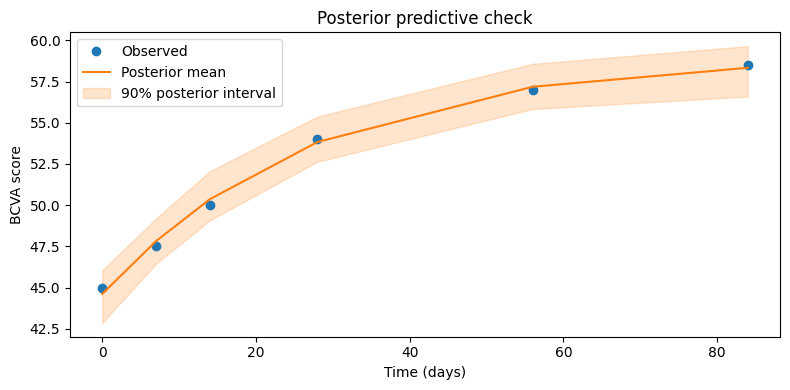

In [10]:
posterior_bcva = fit.stan_variable("bcva_rep")
mean_bcva = posterior_bcva.mean(axis=0)
lower, upper = np.percentile(posterior_bcva, [5, 95], axis=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(patient_df["time"], patient_df["bcva"], "o", label="Observed", color="tab:blue")
plt.plot(patient_df["time"], mean_bcva, label="Posterior mean", color="tab:orange")
plt.fill_between(
    patient_df["time"],
    lower,
    upper,
    color="tab:orange",
    alpha=0.2,
    label="90% posterior interval",
)
plt.xlabel("Time (days)")
plt.ylabel("BCVA score")
plt.title("Posterior predictive check")
plt.legend()
plt.tight_layout()
plt.show()
